---
title: Estimation and Prediction in AR models
---

In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Dataset One: Personal Consumption Expenditures from FRED

The following data is on personal consumption expenditures from FRED (https://fred.stlouisfed.org/series/PCEC). It measures the total amount of money that U.S. households spend on goods and services. This is a time-series record of that spending reported quarterly in billions of dollars (with seasonal adjustment). This measure is compiled by the Bureau of Economic Analysis (BEA) and is a key indicator used to track consumer demand and overall economic activity in the United States.

  observation_date     PCEC
0       1947-01-01  156.161
1       1947-04-01  160.031
2       1947-07-01  163.543
3       1947-10-01  167.672
4       1948-01-01  170.372


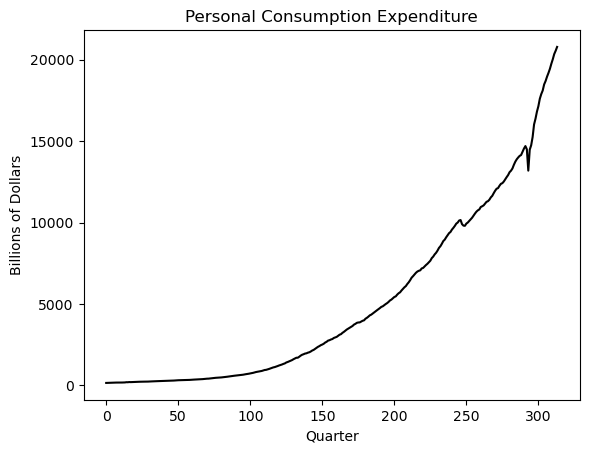

In [444]:
pcec = pd.read_csv("PCEC_30Oct2025.csv")
print(pcec.head())
y = pcec['PCEC'].to_numpy()
plt.plot(y, color = 'black')
plt.xlabel('Quarter')
plt.ylabel('Billions of Dollars')
plt.title('Personal Consumption Expenditure')
plt.show()

We will fit AR(p) models to this dataset, and use the fitted models to predict future values. Let us leave the last 12 observations (corresponding to three years) as test values, and the remaining data form the training data. We will fit AR(p) models to the training data, predict the test values and then compare the predictions with the actual test values. 

In [445]:
n = len(y)
tme = range(1, n+1)
#n_test = 50
n_test = 19 
n_train = n - n_test
y_train = y[:n_train]
tme_train = tme[:n_train]
y_test = y[n_train:]
tme_test = tme[n_train:]

Below, we fit AR(1) to the training data. There are two ways of doing this. Either manually create $y$ and $X$ and use OLS, or use the AutoReg function from statsmodels. 

In [446]:
p = 1
yreg = y_train[p:] #these are the response values in the autoregression
Xmat = np.ones((n_train-p, 1)) #this will be the design matrix (X) in the autoregression
for j in range(1, p+1):
    col = y_train[p-j : n_train-j].reshape(-1, 1)
    Xmat = np.column_stack([Xmat, col])

armod = sm.OLS(yreg, Xmat).fit()
print(armod.params)
print(armod.summary())

[16.73313785  1.00766445]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.192e+05
Date:                Fri, 31 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:46:54   Log-Likelihood:                -1813.7
No. Observations:                 294   AIC:                             3631.
Df Residuals:                     292   BIC:                             3639.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.7331     

In [447]:
from statsmodels.tsa.ar_model import AutoReg
armod_sm = AutoReg(y_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  295
Model:                     AutoReg(1)   Log Likelihood               -1813.666
Method:               Conditional MLE   S.D. of innovations            115.583
Date:                Fri, 31 Oct 2025   AIC                           3633.332
Time:                        01:46:55   BIC                           3644.382
Sample:                             1   HQIC                          3637.757
                                  295                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.7331      9.345      1.791      0.073      -1.583      35.050
y.L1           1.0077      0.002    649.681      0.000       1.005       1.011
                                    Roots           

Here are some observations comparing the above two outputs:  
1. The parameter estimates are exactly the same.
2. The regression summary gives t-scores corresponding to each parameter estimate while the AutoReg summary only gives z-scores
3. The standard errors are slightly different.

The standard errors given by the regression summary correspond to the square roots of the diagonal entries of: 
\begin{equation*}
   \hat{\sigma}^2 (X^T X)^{-1} ~~~ \text{ where } \hat{\sigma}^2 = \sqrt{\frac{\|Y - X \hat{\beta}\|^2}{n-2p-1}}
\end{equation*}
while the standard errors reported by AutoReg summary correspond to the square roots of the diagonal entries of:
\begin{equation*}
   \hat{\sigma}_{\text{MLE}}^2 (X^T X)^{-1} ~~~ \text{ where } \hat{\sigma}_{\text{MLE}}^2 = \sqrt{\frac{\|Y - X \hat{\beta}\|^2}{n-p}}
\end{equation*}

Here is how the fitted model can be used to predict the test observations. 

In [448]:
k = n_test
fcast = armod_sm.get_prediction(start = n_train, end = n_train+k-1)
fcast_mean = fcast.predicted_mean #this gives point predictions for the future values of the time series 

The method that the above function uses to calculate the predictions was detailed in class; and is captured in the code below. 

In [449]:
#Predictions
yhat = np.concatenate([y_train.astype(float), np.full(k, -9999)]) #extend data by k placeholder values
phi_vals = armod_sm.params
for i in range(1, k+1):
    ans = phi_vals[0]
    for j in range(1, p+1):
        ans += phi_vals[j] * yhat[n_train+i-j-1]
    yhat[n_train+i-1] = ans
predvalues = yhat[n_train:]

#Check that both predictions are identical:
print(np.column_stack([predvalues, fcast_mean]))
preds_nolog = fcast_mean

[[14606.9142231  14606.9142231 ]
 [14735.60125891 14735.60125891]
 [14865.2746095  14865.2746095 ]
 [14995.94183441 14995.94183441]
 [15127.61055115 15127.61055115]
 [15260.28843559 15260.28843559]
 [15393.98322245 15393.98322245]
 [15528.70270571 15528.70270571]
 [15664.45473911 15664.45473911]
 [15801.24723657 15801.24723657]
 [15939.08817267 15939.08817267]
 [16077.98558312 16077.98558312]
 [16217.94756519 16217.94756519]
 [16358.98227825 16358.98227825]
 [16501.09794419 16501.09794419]
 [16644.30284789 16644.30284789]
 [16788.60533778 16788.60533778]
 [16934.01382624 16934.01382624]
 [17080.53679013 17080.53679013]]


Below we plot the predictions along with the actual test observations. 

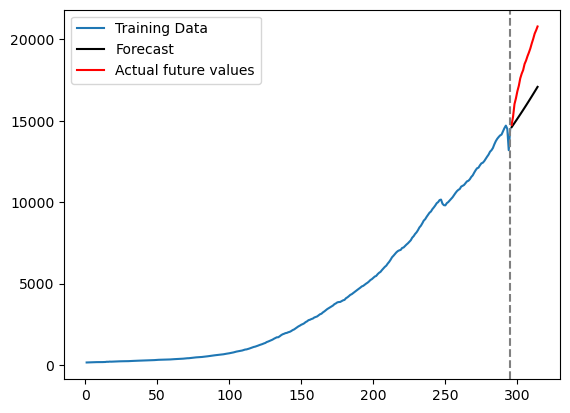

In [450]:
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, fcast_mean, label = 'Forecast', color = 'black')
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

Next we discuss prediction uncertainty quantification. The prediction standard errors, and the associated uncertainty intervals, are calculated as follows. 

In [451]:
fcast_se = fcast.se_mean
alpha = 0.05
from scipy import stats
z_alpha_half = stats.norm.ppf(1 - alpha/2)
predlower = predvalues - z_alpha_half * fcast_se
predupper = predvalues + z_alpha_half * fcast_se
fcast_int = fcast.conf_int()
print(np.column_stack([predlower, predupper, fcast_int]))


[[14380.37479095 14833.45365525 14380.37479095 14833.45365525]
 [14413.99602915 15057.20648867 14413.99602915 15057.20648867]
 [14469.87407837 15260.67514062 14469.87407837 15260.67514062]
 [14537.61070798 15454.27296085 14537.61070798 15454.27296085]
 [14613.19828795 15642.02281435 14613.19828795 15642.02281435]
 [14694.59243385 15825.98443733 14694.59243385 15825.98443733]
 [14780.58587329 16007.3805716  14780.58587329 16007.3805716 ]
 [14870.39721667 16187.00819474 14870.39721667 16187.00819474]
 [14963.48775649 16365.42172173 14963.48775649 16365.42172173]
 [15059.4685554  16543.02591775 15059.4685554  16543.02591775]
 [15158.04876856 16720.12757678 15158.04876856 16720.12757678]
 [15259.00483287 16896.96633336 15259.00483287 16896.96633336]
 [15362.16107099 17073.7340594  15362.16107099 17073.7340594 ]
 [15467.37693502 17250.58762149 15467.37693502 17250.58762149]
 [15574.53830884 17427.65757953 15574.53830884 17427.65757953]
 [15683.5513957  17605.05430009 15683.5513957  17605.05

Below we plot the predictions along with uncertainty intervals.

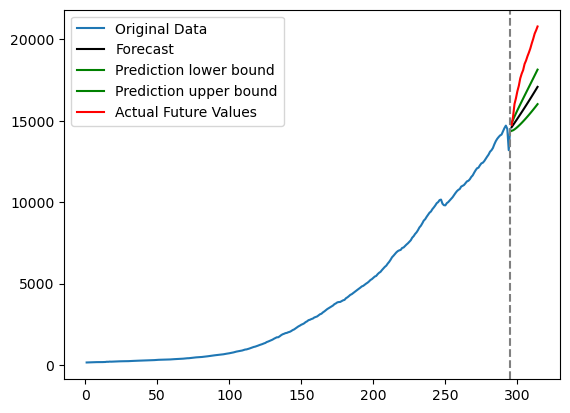

In [452]:
#Plotting predictions along with uncertainty:
plt.plot(tme_train, y_train, label = 'Original Data')
plt.plot(tme_test, predvalues, label = 'Forecast', color = 'black')
plt.plot(tme_test, predlower, color = 'green', label = 'Prediction lower bound')
plt.plot(tme_test, predupper, color = 'green', label = 'Prediction upper bound')
plt.plot(tme_test, y_test, color = 'red', label = 'Actual Future Values')
plt.legend()
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.show()

In this example, the predicted values are somewhat below the actual test values. 

Instead of applying AR models, directly to the raw data, it is common practice to apply them to the logarithms. 

In [453]:
ylog_train = np.log(y_train)
ylog_test = np.log(y_test)

In [454]:
armod_sm = AutoReg(ylog_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  295
Model:                     AutoReg(1)   Log Likelihood                 877.497
Method:               Conditional MLE   S.D. of innovations              0.012
Date:                Fri, 31 Oct 2025   AIC                          -1748.994
Time:                        01:47:02   BIC                          -1737.943
Sample:                             1   HQIC                         -1744.569
                                  295                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0273      0.004      7.271      0.000       0.020       0.035
y.L1           0.9984      0.000   2033.940      0.000       0.997       0.999
                                    Roots           

Predictions are obtained as follows. 

In [455]:
fcast = armod_sm.get_prediction(start = n_train, end = n_train+k-1)
fcast_mean = fcast.predicted_mean #this gives the point predictions

Prediction uncertainty intervals are obtained as follows. 

In [456]:
fcast_se = fcast.se_mean
alpha = 0.05
z_alpha_half = stats.norm.ppf(1 - alpha/2)
predlower = fcast_mean - z_alpha_half * fcast_se
predupper = fcast_mean + z_alpha_half * fcast_se
fcast_int = fcast.conf_int()
print(np.column_stack([predlower, predupper, fcast_int]))

[[9.56863084 9.61658311 9.56863084 9.61658311]
 [9.57084537 9.63860634 9.57084537 9.63860634]
 [9.57536344 9.65828756 9.57536344 9.65828756]
 [9.58106762 9.67674429 9.58106762 9.67674429]
 [9.5875247  9.69440978 9.5875247  9.69440978]
 [9.59451235 9.71150643 9.59451235 9.71150643]
 [9.60189838 9.72816647 9.60189838 9.72816647]
 [9.60959661 9.74447617 9.60959661 9.74447617]
 [9.61754713 9.76049548 9.61754713 9.76049548]
 [9.6257063  9.7762681  9.6257063  9.7762681 ]
 [9.63404116 9.79182707 9.63404116 9.79182707]
 [9.64252607 9.80719807 9.64252607 9.80719807]
 [9.65114064 9.82240156 9.65114064 9.82240156]
 [9.65986833 9.83745414 9.65986833 9.83745414]
 [9.6686955  9.8523695  9.6686955  9.8523695 ]
 [9.67761074 9.86715912 9.67761074 9.86715912]
 [9.68660442 9.88183269 9.68660442 9.88183269]
 [9.69566826 9.89639854 9.69566826 9.89639854]
 [9.70479516 9.91086384 9.70479516 9.91086384]]


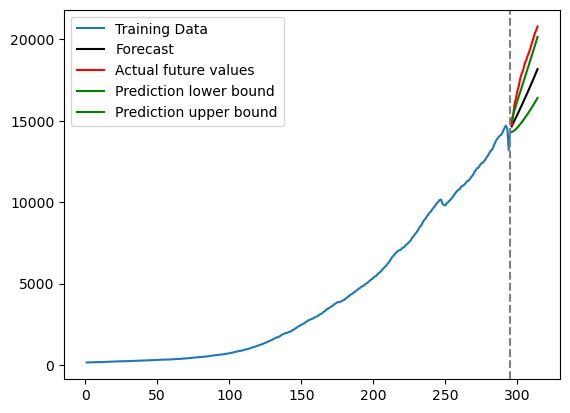

In [457]:
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, np.exp(fcast_mean), label = 'Forecast', color = 'black') #Note the exponentiation
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.plot(tme_test, np.exp(predlower), color = 'green', label = 'Prediction lower bound')
plt.plot(tme_test, np.exp(predupper), color = 'green', label = 'Prediction upper bound')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

Note that now the predictions are slightly closer to the actual observations. 

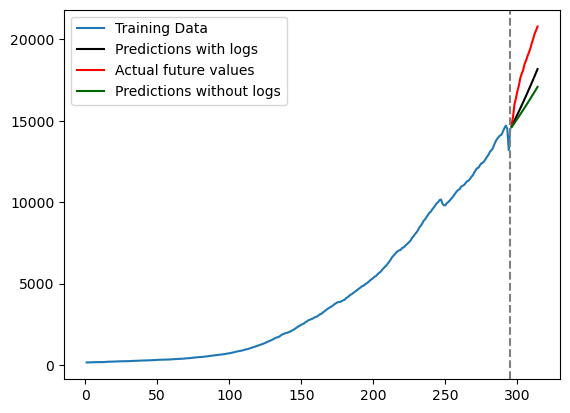

In [458]:
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, np.exp(fcast_mean), label = 'Predictions with logs', color = 'black') #Note the exponentiation
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.plot(tme_test, preds_nolog, color = 'darkgreen',  label = 'Predictions without logs')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

## Dataset Two: House Price Data from FRED

  observation_date  ASPUS
0       1963-01-01  19300
1       1963-04-01  19400
2       1963-07-01  19200
3       1963-10-01  19600
4       1964-01-01  19600


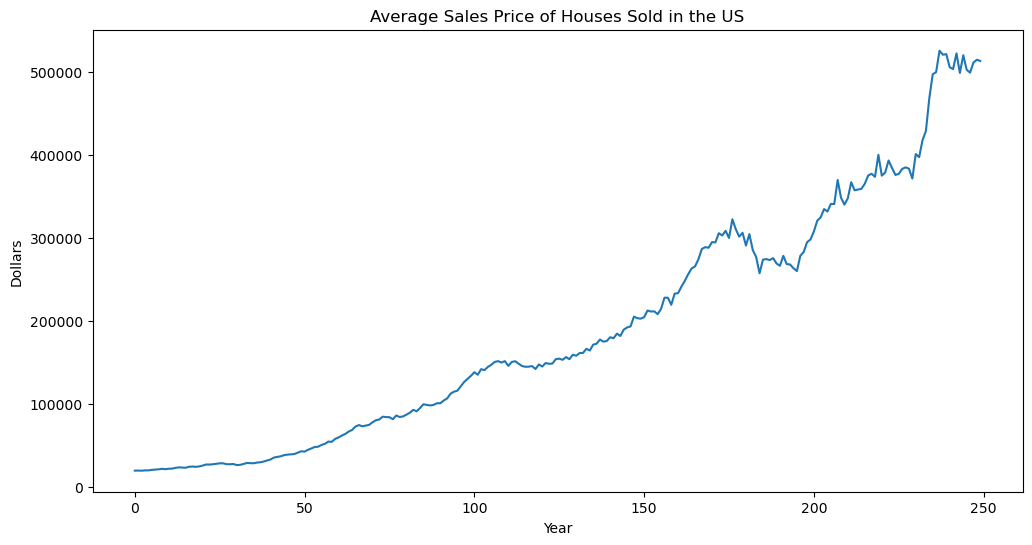

In [410]:
#The following is FRED data on Average Sales Price of Houses Sold for the US (https://fred.stlouisfed.org/series/ASPUS)
hprice = pd.read_csv('ASPUS_October2025.csv')
print(hprice.head())
y = hprice['ASPUS'].to_numpy()
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.xlabel('Year')
plt.ylabel('Dollars')
plt.title('Average Sales Price of Houses Sold in the US')
plt.show()

Training-test split: 

In [423]:
n = len(y)
tme = range(1, n+1)
#n_test = 50
n_test = 100
n_train = n - n_test
y_train = y[:n_train]
tme_train = tme[:n_train]
y_test = y[n_train:]
tme_test = tme[n_train:]

In [424]:
p = 1
from statsmodels.tsa.ar_model import AutoReg
armod_sm = AutoReg(y_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  150
Model:                     AutoReg(1)   Log Likelihood               -1371.075
Method:               Conditional MLE   S.D. of innovations           2399.236
Date:                Thu, 30 Oct 2025   AIC                           2748.150
Time:                        16:14:00   BIC                           2757.161
Sample:                             1   HQIC                          2751.811
                                  150                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        597.9359    366.248      1.633      0.103    -119.896    1315.768
y.L1           1.0071      0.003    290.953      0.000       1.000       1.014
                                    Roots           

In [425]:
k = n_test
fcast = armod_sm.get_prediction(start = n_train, end = n_train+k-1)
fcast_mean = fcast.predicted_mean #this gives point predictions for the future values of the time series 
preds_nolog = fcast_mean

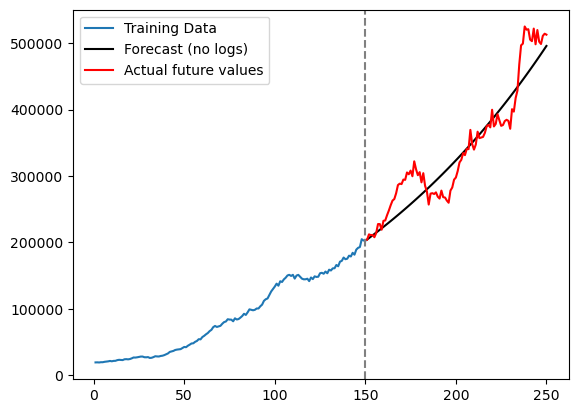

In [426]:
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, fcast_mean, label = 'Forecast (no logs)', color = 'black')
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

In [427]:
fcast_se = fcast.se_mean
alpha = 0.05
z_alpha_half = stats.norm.ppf(1 - alpha/2)
predlower = fcast_mean - z_alpha_half * fcast_se
predupper = fcast_mean + z_alpha_half * fcast_se
fcast_int = fcast.conf_int()
print(np.column_stack([predlower, predupper, fcast_int]))

[[199725.76615832 209130.59668745 199725.76615832 209130.59668745]
 [199796.937386   213144.45231145 199796.937386   213144.45231145]
 [200324.99344089 216730.28966636 200324.99344089 216730.28966636]
 [201093.84012565 220104.40693304 201093.84012565 220104.40693304]
 [202020.13480094 223350.35217579 202020.13480094 223350.35217579]
 [203061.32477668 226510.88496127 203061.32477668 226510.88496127]
 [204192.2527195  229611.3709613  204192.2527195  229611.3709613 ]
 [205396.61252049 232668.32609549 205396.61252049 232668.32609549]
 [206663.14243429 235693.22340245 206663.14243429 235693.22340245]
 [207983.69414988 238694.4239796  207983.69414988 238694.4239796 ]
 [209352.15867435 241678.25110984 209352.15867435 241678.25110984]
 [210763.82585245 244649.63075271 210763.82585245 244649.63075271]
 [212214.98112465 247612.49479698 212214.98112465 247612.49479698]
 [213702.64028876 250570.04630982 213702.64028876 250570.04630982]
 [215224.36863025 253524.94041734 215224.36863025 253524.94041

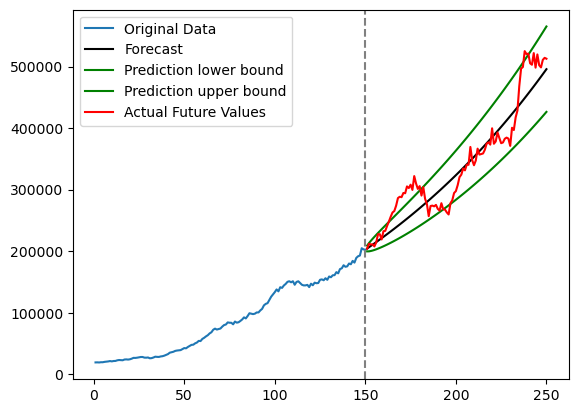

In [428]:
#Plotting predictions along with uncertainty:
plt.plot(tme_train, y_train, label = 'Original Data')
plt.plot(tme_test, fcast_mean, label = 'Forecast', color = 'black')
plt.plot(tme_test, predlower, color = 'green', label = 'Prediction lower bound')
plt.plot(tme_test, predupper, color = 'green', label = 'Prediction upper bound')
plt.plot(tme_test, y_test, color = 'red', label = 'Actual Future Values')
plt.legend()
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.show()

Now we take logs. 

In [429]:
ylog_train = np.log(y_train)
ylog_test = np.log(y_test)

In [430]:
armod_sm = AutoReg(ylog_train, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  150
Model:                     AutoReg(1)   Log Likelihood                 349.431
Method:               Conditional MLE   S.D. of innovations              0.023
Date:                Thu, 30 Oct 2025   AIC                           -692.861
Time:                        16:14:04   BIC                           -683.849
Sample:                             1   HQIC                          -689.200
                                  150                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0530      0.028      1.912      0.056      -0.001       0.107
y.L1           0.9967      0.002    401.775      0.000       0.992       1.002
                                    Roots           

In [431]:
fcast = armod_sm.get_prediction(start = n_train, end = n_train+k-1)
fcast_mean = fcast.predicted_mean #this gives the point predictions

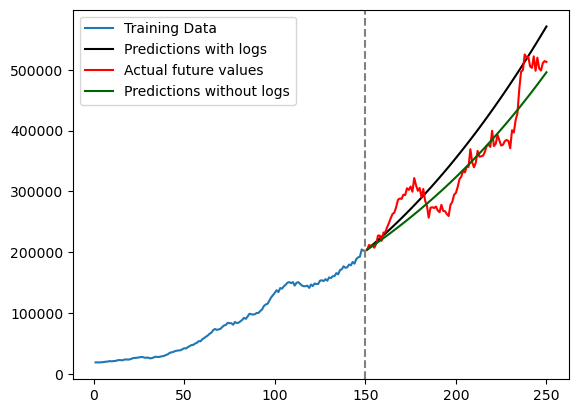

In [432]:
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, np.exp(fcast_mean), label = 'Predictions with logs', color = 'black') #Note the exponentiation
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.plot(tme_test, preds_nolog, color = 'darkgreen',  label = 'Predictions without logs')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

In [433]:
fcast_se = fcast.se_mean
alpha = 0.05
z_alpha_half = stats.norm.ppf(1 - alpha/2)
predlower = fcast_mean - z_alpha_half * fcast_se
predupper = fcast_mean + z_alpha_half * fcast_se
fcast_int = fcast.conf_int()
print(np.column_stack([predlower, predupper, fcast_int]))

[[12.18473427 12.27563044 12.18473427 12.27563044]
 [12.17815671 12.30648897 12.17815671 12.30648897]
 [12.17596656 12.33287905 12.17596656 12.33287905]
 [12.17603963 12.35692514 12.17603963 12.35692514]
 [12.17755168 12.37945174 12.17755168 12.37945174]
 [12.18007928 12.40088258 12.18007928 12.40088258]
 [12.18337047 12.42146985 12.18337047 12.42146985]
 [12.18726086 12.44137823 12.18726086 12.44137823]
 [12.19163608 12.46072235 12.19163608 12.46072235]
 [12.19641275 12.47958586 12.19641275 12.47958586]
 [12.20152783 12.49803205 12.20152783 12.49803205]
 [12.20693229 12.51611023 12.20693229 12.51611023]
 [12.21258708 12.5338597  12.21258708 12.5338597 ]
 [12.21846052 12.55131241 12.21846052 12.55131241]
 [12.22452647 12.56849476 12.22452647 12.56849476]
 [12.23076305 12.58542888 12.23076305 12.58542888]
 [12.23715175 12.60213355 12.23715175 12.60213355]
 [12.24367673 12.61862486 12.24367673 12.61862486]
 [12.25032431 12.63491676 12.25032431 12.63491676]
 [12.25708259 12.65102139 12.25

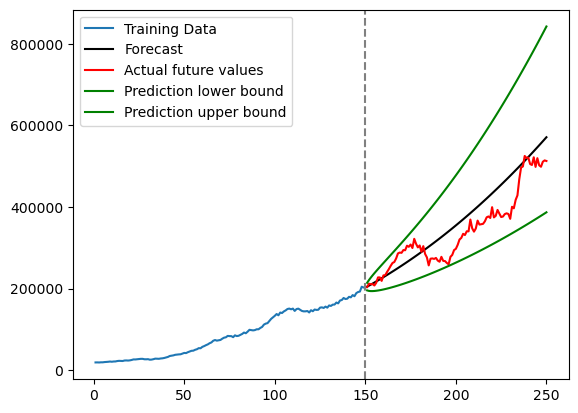

In [434]:
plt.plot(tme_train, y_train, label = 'Training Data')
plt.plot(tme_test, np.exp(fcast_mean), label = 'Forecast', color = 'black') #Note the exponentiation
plt.plot(tme_test, y_test, color = 'red',  label = 'Actual future values')
plt.plot(tme_test, np.exp(predlower), color = 'green', label = 'Prediction lower bound')
plt.plot(tme_test, np.exp(predupper), color = 'green', label = 'Prediction upper bound')
plt.axvline(x=n_train, color='gray', linestyle='--')
plt.legend()
plt.show()

## How are the Prediction Uncertainties actually calculated?

We now calculate the prediction standard errors directly using the method described in class. The first step is to fit the AR(p) model and then to obtain estimates of $\phi_0, \dots, \phi_p$ as well as $\sigma$. There are two estimates of $\sigma$ (only difference being the denominators: $n-p$ vs $n-2p-1$).

In [435]:
yreg = ylog_train[p:] #these are the response values in the autoregression
Xmat = np.ones((n_train-p, 1)) #this will be the design matrix (X) in the autoregression
for j in range(1, p+1):
    col = ylog_train[p-j : n_train-j]
    Xmat = np.column_stack([Xmat, col])

armod = sm.OLS(yreg, Xmat).fit()
sighat = np.sqrt(np.mean(armod.resid ** 2)) #note that this mean is taken over n-p observations (this is the MLE for sigma)
resdf = n_train - 2*p - 1
sigols = np.sqrt((np.sum(armod.resid ** 2))/resdf)
print(sighat, sigols)

0.023188223680961746 0.023345433777514888


The two estimates of $\sigma$ lead to two values for standard errors. 

In [436]:
covmat = (sighat ** 2) * np.linalg.inv(np.dot(Xmat.T, Xmat))
covmat_ols = (sigols ** 2) * np.linalg.inv(np.dot(Xmat.T, Xmat))
print(np.sqrt(np.diag(covmat)))
print(armod_sm.bse)
print(np.sqrt(np.diag(covmat_ols)))
print(armod.bse)

[0.02770428 0.00248065]
[0.02770428 0.00248065]
[0.02789211 0.00249746]
[0.02789211 0.00249746]


The following code computes the prediction standard errors. It uses the matrix recursion method described in class. 

In [437]:
sigest = sighat
Gamhat = np.array([[sigest ** 2]])
vkp = np.array([[armod.params[1]]])

for i in range(1, k):
    covterm = Gamhat @ vkp 
    varterm = sigest**2 + (vkp.T @ (Gamhat @ vkp)) 
    Gamhat = np.block([
        [Gamhat,    covterm],
        [covterm.T, varterm ]
    ])
    if i < p:
        new_coef = armod.params[i+1]
        vkp = np.vstack([ [new_coef], vkp ])
    else:
        vkp = np.vstack([ [0], vkp ])
predsd = np.sqrt(np.diag(Gamhat))

#Check that this method produces the same standard errors as those computed by .se_mean:
print(np.column_stack([predsd, fcast_se]))

[[0.02318822 0.02318822]
 [0.03273842 0.03273842]
 [0.04002943 0.04002943]
 [0.04614511 0.04614511]
 [0.05150606 0.05150606]
 [0.05632841 0.05632841]
 [0.06074075 0.06074075]
 [0.06482705 0.06482705]
 [0.06864572 0.06864572]
 [0.07223936 0.07223936]
 [0.07564022 0.07564022]
 [0.07887337 0.07887337]
 [0.08195881 0.08195881]
 [0.08491276 0.08491276]
 [0.08774863 0.08774863]
 [0.09047764 0.09047764]
 [0.09310931 0.09310931]
 [0.09565179 0.09565179]
 [0.09811212 0.09811212]
 [0.10049644 0.10049644]
 [0.10281014 0.10281014]
 [0.10505799 0.10505799]
 [0.10724422 0.10724422]
 [0.10937263 0.10937263]
 [0.11144661 0.11144661]
 [0.11346926 0.11346926]
 [0.11544334 0.11544334]
 [0.1173714  0.1173714 ]
 [0.11925576 0.11925576]
 [0.12109854 0.12109854]
 [0.12290168 0.12290168]
 [0.12466699 0.12466699]
 [0.12639613 0.12639613]
 [0.12809063 0.12809063]
 [0.12975194 0.12975194]
 [0.13138138 0.13138138]
 [0.1329802  0.1329802 ]
 [0.13454956 0.13454956]
 [0.13609054 0.13609054]
 [0.13760417 0.13760417]
